# Cross Sell

In [1]:
# import the required packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score

from datetime import timedelta

In [2]:
# import the data 
routes = pd.read_csv("./data/routes.csv")
products = pd.read_csv("./data/products.csv")
customers = pd.read_csv("./data/customers.csv")
visitdetails = pd.read_csv("./data/visitdetails.csv")
visits = pd.read_csv("./data/visits.csv")

C:\Users\stefd\AppData\Local\Temp\ipykernel_9800\987823172.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  visits = pd.read_csv("./data/visits.csv")


In [5]:
visits["PaymentTerm"].value_counts()

cash    76391
tbp       910
Name: PaymentTerm, dtype: int64

# 0. Introduction to the case

This **cross-sell case** is about a company in the food industry. Sales representatives drive around to visit customers and try to convince them to buy more or new products. Based on the **profitability of the customer**, sales representatives decide whether they will add them to their route or not. 

The **goal of this case** is to construct a model that is able to **predict which product a customer will buy next**. 

# 1. Data Exploration

## 1.1. Customers

Let's first inspect the **shape** and the **first few observations** of the ``customers`` dataframe.

In [6]:
# inspect shape
customers.shape

(5709, 5)

In [7]:
# check first observations of customers dataset
customers.head()


,CustomerID,RouteID,CustomerType,ZIP,SeasonType
0,719747,219019962,Private,39500,All time
1,719752,219019962,Private,39500,All time
2,719757,219019962,Private,39500,All time
3,719762,219019962,Private,39500,All time
4,719768,219019962,Private,39500,All time


The table above contains several pieces of **information about customers**, i.e. on which route they are located (``RouteID``), the type of customer they are (``CustomerType``), the ZIP code of the area they are located in (``ZIP``), and the season in which they are customers (``SeasonType``). 

Based on the table above, we may suspect that the variable ``CustomerID`` represents a unique ID for each customer. To make sure that this is the case, we have to **check** whether ``CustomerID`` is unique. 

In [8]:
# inspect if CustomerID is unique in customers dataset
customers["CustomerID"].is_unique

True

Furthermore, to gain a better understanding of the variables in the table, we **check out the different categories** (and the **frequency** with which the occur) of the variables ``CustomerType`` and ``SeasonType``

In [9]:
# inspect SeasonType categories and frequencies
customers["SeasonType"].value_counts()

All time     5554
Summer        150
Christmas       3
Winter          1
Name: SeasonType, dtype: int64

In [10]:
# inspect CustomerType categories and frequencies
customers["CustomerType"].value_counts()

Private     5579
FBSC          97
Catering      33
Name: CustomerType, dtype: int64

## 1.2. Products

Let's now inspect the **shape** and the **first few observations** of the ``products`` dataframe

In [11]:
# inspect shape
products.shape

(317, 4)

In [12]:
# check first observations of products dataset
products.head()

,ProductID,Category,Family,Price
0,21276088156846,Product,Scoop Ice,16.60
1,17925360348038,Product,Scoop Ice,16.60
2,23695,Product,Scoop Ice,3.95
3,22881244634648,Product,Meals,15.90
4,23771,Product,Ice Cakes,4.90


Again, we need to **verify** whether ``ProductID`` is unique.

In [13]:
# check if ProductID is unique in table
products["ProductID"].is_unique

True

We also would like to know the **number of different categories** (and **frequencies**) for the variables ``Category`` and ``Family``. 

In [15]:
# inspect Category categories and frequencies
products["Category"].value_counts()

Product    287
Coupon      28
POS          2
Name: Category, dtype: int64

In [14]:
# inspect Family categories and frequencies
products["Family"].value_counts()

Scoop Ice             75
Hand Ice              46
Meals                 39
Cups                  37
Ice Cakes             23
Coffee                23
Individual Dessert    22
Garniture             12
Assortments            8
POS inside             2
BIG                    2
Name: Family, dtype: int64

For the variable ``Family``, represent this visually by means of a **barplot**. Thus, the ``x-axis`` should represent the **product families** and the ``y-axis`` should display the **number of products** in each product family. 

In [16]:
# first inspect number of products per product family
family_counts = pd.DataFrame(products["Family"].value_counts().reset_index())

# rename columns
family_counts.columns = ["family", "num_products"]

# show
family_counts

,family,num_products
0,Scoop Ice,75
1,Hand Ice,46
2,Meals,39
3,Cups,37
4,Ice Cakes,23
5,Coffee,23
6,Individual Dessert,22
7,Garniture,12
8,Assortments,8
9,POS inside,2


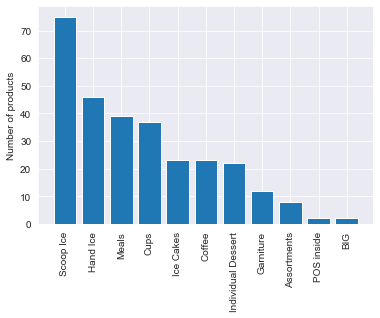

In [17]:
# plot
plt.bar(family_counts["family"], family_counts["num_products"])
plt.xticks(range(len(family_counts)), family_counts["family"], rotation=90)
plt.ylabel("Number of products")
plt.show()

## 1.3. Visits

Inspect the **shape** and the **first few observations** of the ``products`` dataframe.

In [18]:
# inspect shape
visits.shape

(240415, 7)

In [21]:
# inspect first observations of visits dataset
visits.head()

,VisitID,CustomerID,SalesRepresentativeID,VisitDate,Amount,PaymentTerm,Outcome
0,55693717,720358,23186288605042,2007-05-09 15:02:11,0.0,NaN,NOTHING NEEDED
1,58048030,724530,23186288605042,2007-07-12 15:29:01,0.0,NaN,NOTHING NEEDED
2,55685132,1400422,23845760556442,2007-05-09 13:11:41,0.0,NaN,NOTHING NEEDED
3,52141748,1396635,20126680425436,2007-01-12 14:09:37,0.0,NaN,NOTHING NEEDED
4,52141749,1396640,20126680425436,2007-01-12 14:09:38,0.0,NaN,NOTHING NEEDED


This table contains **one row per visit**. For each visit, it shows which customer (``CustomerID``) has been visited by which sales representative (``SalesRepresentativeID``) on what day (``VisitDate``). Furthermore, it also shows the outcome of the visit (``Outcome``), the amount that was purchased (``Amount``) and the payment term of the purchase (``PaymentTerm``).

First of all, we have to **convert** ``VisitDate`` to the appropriate ``Datetime`` type (HINT: use Google to find an overview of the correct date formats).

In [20]:
# convert VisitDate of visits DataFrame to pandas Datetime type
visits["VisitDate"] = pd.to_datetime(visits["VisitDate"], format="%d-%b-%y %I.%M.%S.000000000 %p")

We also need to **check** whether ``VisitID`` and ``CustomerID`` are unique. 

In [22]:
# check if VisitID is unique
visits["VisitID"].is_unique

True

In [23]:
# check if CustomerID is unique
visits["CustomerID"].is_unique

False

As ``VisitID`` is unique while ``CustomerID`` is not, this means that **a customer can be visited multiple times**. However, each visit is identified by a unique ``VisitID``.

Finally, let's check the **different possible outcomes** and the **proportion** with which they occur. 

In [24]:
# inspect the proportion of outcomes of the visits
visits["Outcome"].value_counts(normalize=True)*100

NOTHING NEEDED    38.997151
SALES             32.830730
NOT HOME          28.172119
Name: Outcome, dtype: float64

## 1.4. VisitDetails

Inspect the **shape** and the **first few observations** of the visitdetails dataframe.

In [25]:
# inspect shape
visitdetails.shape

(126778, 4)

In [26]:
# inspect visitdetails
visitdetails.head()

,VisitDetailID,ProductID,Quantity,VisitID
0,56012184,23686,1,56012182
1,56012248,290318682,1,56012247
2,56012265,23727,1,56012264
3,56011750,23735,1,56011749
4,56011352,23760,1,56011351


Check whether ``VisitDetailID``, ``ProductID`` and ``VisitID`` are **unique**. 

In [27]:
# check if VisitDetailID is unique
visitdetails["VisitDetailID"].is_unique

True

In [28]:
# check if ProductID is unique
visitdetails["ProductID"].is_unique

False

In [29]:
# check if VisitID is unique
visitdetails["VisitID"].is_unique

False

As ``VisitDetailID`` is unique and the other two variables are not, this means that the dataframe ``visitdetails`` contains **one row per VisitDetail**. Each VisitDetail is linked to a visit (``VisitID``) and a product (``ProductID``) but each visit can contain multiple VisitDetails. Similarly, products can be linked to several Visitdetails. 

## 1.5. Routes

Inspect the **shape** and the **first few observations** of the routes dataframe.

In [30]:
# inspect shape
routes.shape

(39, 4)

In [31]:
# inspect first observations of routes
routes.head()

,RouteID,Region,WeekOrder,Day
0,70671404,C04,1,Sunday
1,219018687,C04,1,Monday
2,219021882,C04,2,Monday
3,289755468,B25,1,Monday
4,289760478,B25,2,Monday


Check if ``RouteID`` is unique.

In [32]:
# inspect if RouteID is unique
routes["RouteID"].is_unique

True

Check the different regions (``Region``) and the **frequency** with which they occur.

In [33]:
# check region distribution
routes["Region"].value_counts()

C04    11
B25    10
C17    10
B02     8
Name: Region, dtype: int64

# 2. Determine ERD

An **Entity Relationship Diagram** (ERD) represents the *entities* (in this case, the different dataframes) and the *relationships* among these entities. 

It **visualizes** how the different dataframes are connected with eachother and how the most important variables are related to one another. 

Gaining such insights in your data is **important**. For example, when merging different dataframes. 

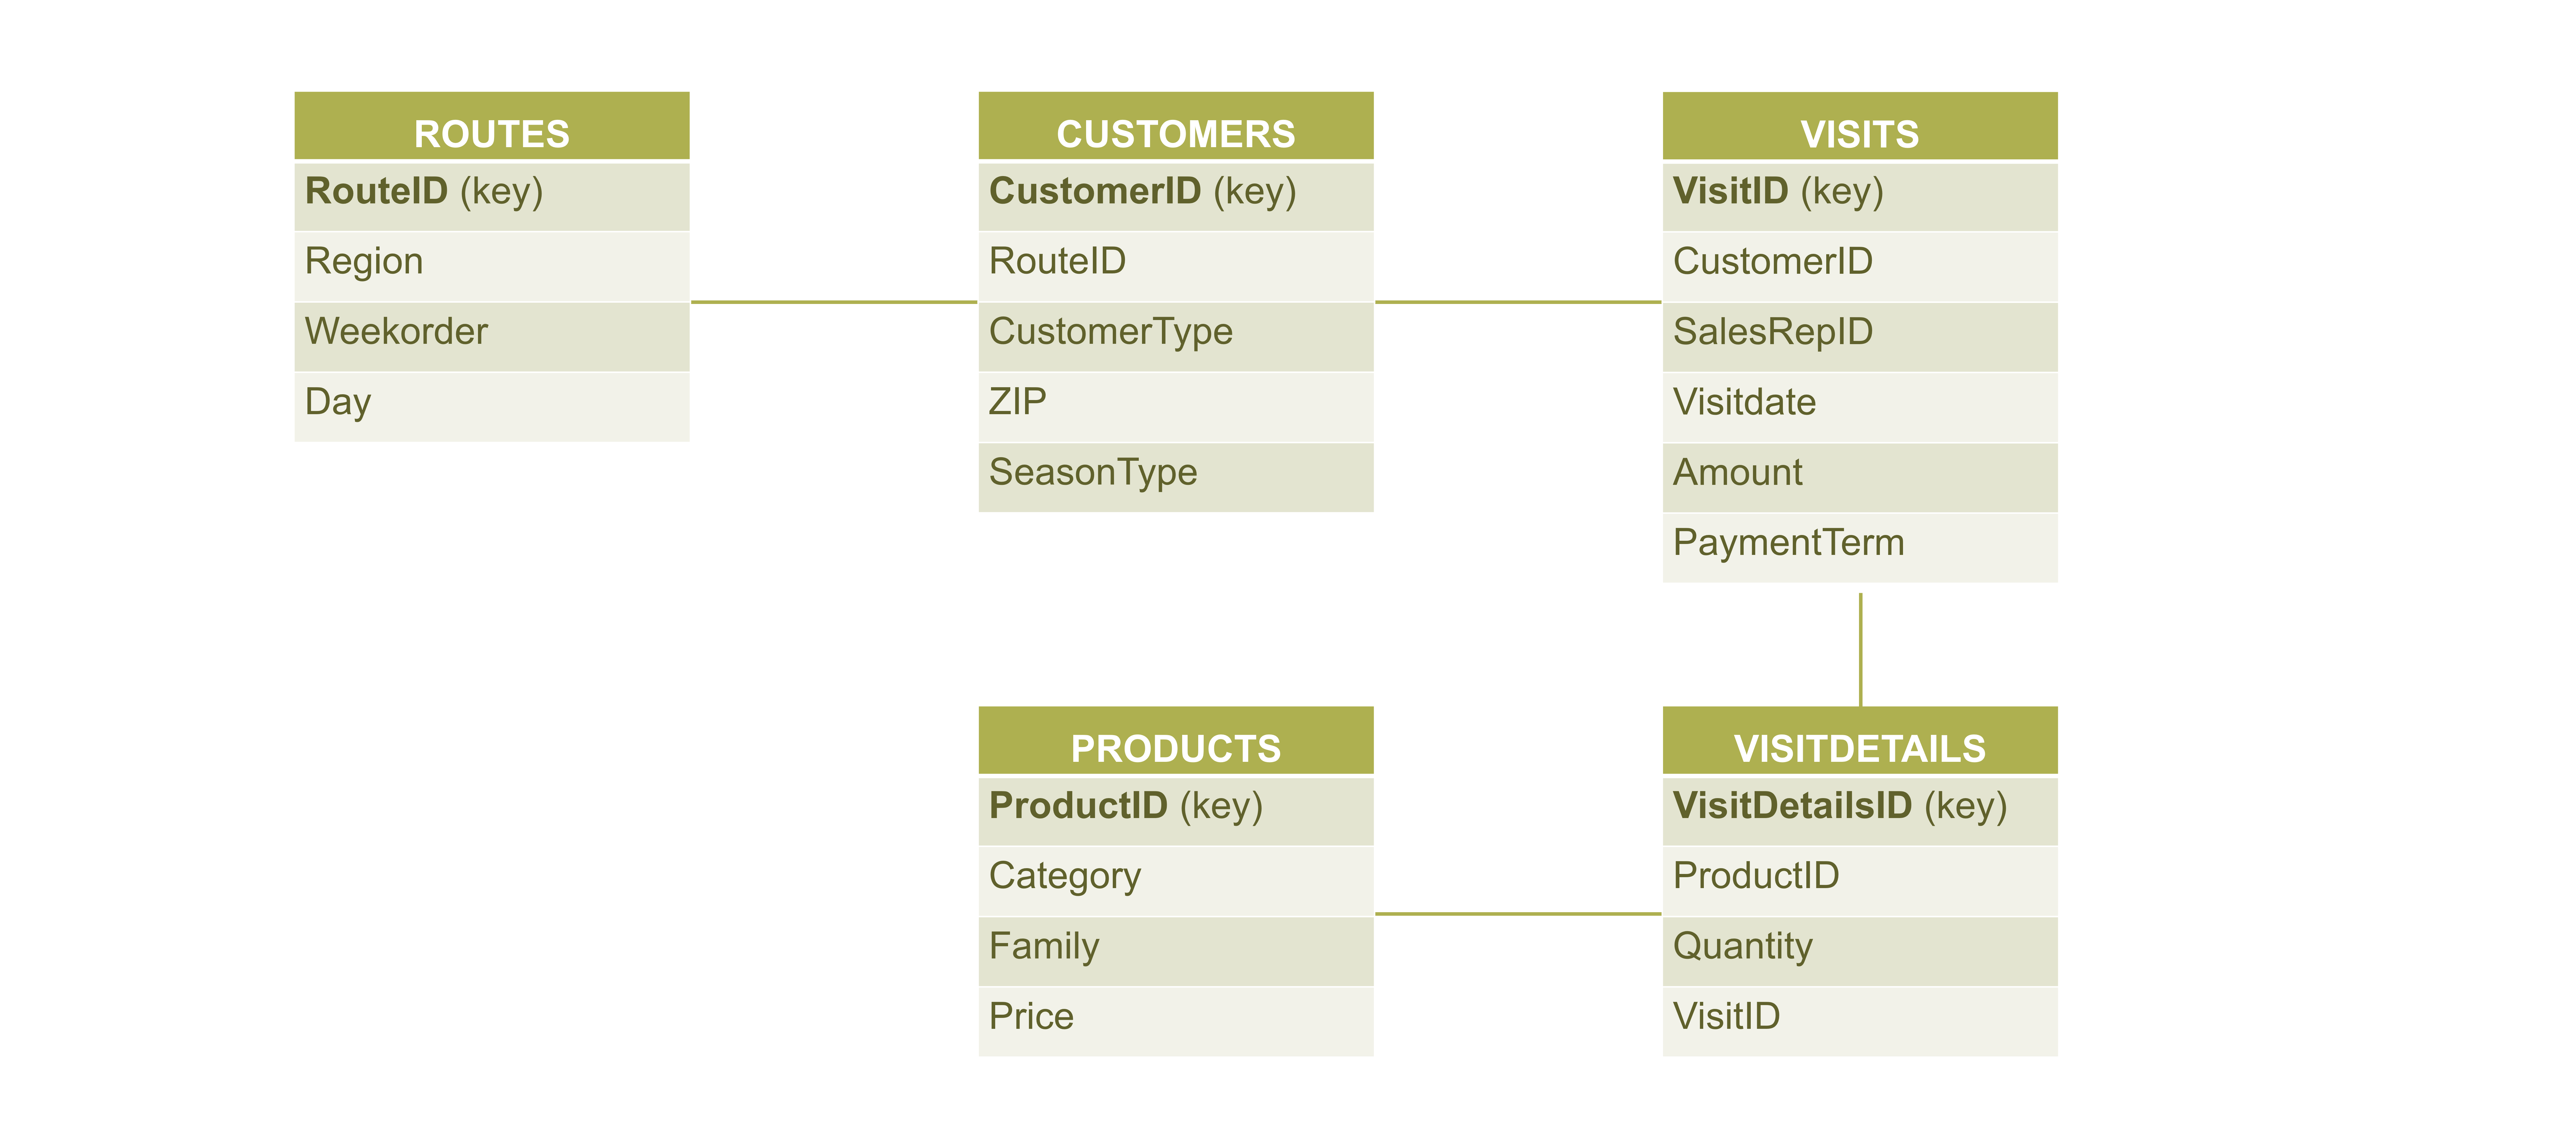

## 2.1. Products and Visitdetails

In [34]:
# The Products and VisitDetails dataset can be linked by the ProductID

# check if ProductID is unique in Products
print("ProductID unique in Products? %s" %products["ProductID"].is_unique)

# check if ProductID is unique in VisitDetails
print("ProductID unique in VisitDetails? %s" %visitdetails["ProductID"].is_unique)

# check if all products from Products table are accounted for in VisitDetails table
print("All ProductIDs from Products accounted for in VisitDetails? %s" %all(products["ProductID"].isin(visitdetails["ProductID"])))

# check if all products from VisitDetails table are accounted for in Products table
print("All ProductIDs from VisitDetails accounted for in Products? %s" %all(visitdetails["ProductID"].isin(products["ProductID"])))

ProductID unique in Products? True
ProductID unique in VisitDetails? False
All ProductIDs from Products accounted for in VisitDetails? True
All ProductIDs from VisitDetails accounted for in Products? True


In [35]:
# get minimum, maxium and average number of visitdetails per product
visitdetails_per_products_stats = visitdetails.groupby("ProductID")["VisitDetailID"].count().reset_index()
visitdetails_per_products_stats.columns = ["ProductID", "num_visitdetails"]
print("Minimum number of visitDetails per product: %s" %min(visitdetails_per_products_stats["num_visitdetails"]))
print("Maximum number of visitDetails per product: %s" %max(visitdetails_per_products_stats["num_visitdetails"]))
print("Average number of visitDetails per product: %s" %np.mean(visitdetails_per_products_stats["num_visitdetails"]))

Minimum number of visitDetails per product: 1
Maximum number of visitDetails per product: 11459
Average number of visitDetails per product: 399.9305993690852


In [ ]:
# every product has 1 to N visitdetails
# every visitdetail is linked to one product 

## 2.2. Visitdetails and Visits

In [36]:
# The Visits and VisitDetails dataset can be linked by the VisitID

# check if VisitID is unique in Visits
print("VisitID unique in Visits? %s" %visits["VisitID"].is_unique)

# check if VisitID is unique in VisitDetails
print("VisitID unique in VisitDetails? %s" %visitdetails["VisitID"].is_unique)

# check if all visits from Visits table are accounted for in VisitDetails table
print("All VisitIDs from Visits accounted for in VisitDetails? %s" %all(visits["VisitID"].isin(visitdetails["VisitID"])))

# check if all products from VisitDetails table are accounted for in Visits table
print("All VisitIDs from VisitDetails accounted for in Visits? %s" %all(visitdetails["VisitID"].isin(visits["VisitID"])))

VisitID unique in Visits? True
VisitID unique in VisitDetails? False
All VisitIDs from Visits accounted for in VisitDetails? False
All VisitIDs from VisitDetails accounted for in Visits? True


In [37]:
# get minimum, maxium and average number of VisitDetails per visit
visitdetails_per_visit_stats = visitdetails.groupby("VisitID")["VisitDetailID"].count().reset_index()
visitdetails_per_visit_stats.columns = ["VisitID", "num_visitdetails"]
print("Minimum number of visitDetails per visit: %s" %min(visitdetails_per_visit_stats["num_visitdetails"]))
print("Maximum number of visitDetails per visit: %s" %max(visitdetails_per_visit_stats["num_visitdetails"]))
print("Average number of visitDetails per visit: %s" %np.mean(visitdetails_per_visit_stats["num_visitdetails"]))

Minimum number of visitDetails per visit: 1
Maximum number of visitDetails per visit: 29
Average number of visitDetails per visit: 1.6074503290266138


In [ ]:
# every visit has 0 to N visitdetails
# every visitdetail is linked to one visit

## 2.3. Visits and Customers

In [38]:
# The Visits and Customers dataset can be linked by the CustomerID

# check if CustomerID is unique in Customers
print("CustomerID unique in cutomers? %s" %customers["CustomerID"].is_unique)

# check if VisitID is unique in Visits
print("CustomerID unique in visits? %s" %visits["CustomerID"].is_unique)

# check if all customers from Customers table are accounted for in Visits table
print("All CustomerIDs from customers accounted for in visits? %s" %all(customers["CustomerID"].isin(visits["CustomerID"])))

# check if all customers from Visits table are accounted for in Customers table
print("All CustomerIDs from visits accounted for in customers? %s" %all(visits["CustomerID"].isin(customers["CustomerID"])))

CustomerID unique in cutomers? True
CustomerID unique in visits? False
All CustomerIDs from customers accounted for in visits? False
All CustomerIDs from visits accounted for in customers? True


In [39]:
# get minimum, maxium and average number of visits per customer
visits_per_customer_stats = visits.groupby("CustomerID")["VisitID"].count().reset_index()
visits_per_customer_stats.columns = ["CustomerID", "num_visits"]
print("Minimum number of visits per customer: %s" %min(visits_per_customer_stats["num_visits"]))
print("Maximum number of visits per customer: %s" %max(visits_per_customer_stats["num_visits"]))
print("Average number of visits per customer: %s" %np.mean(visits_per_customer_stats["num_visits"]))

Minimum number of visits per customer: 1
Maximum number of visits per customer: 116
Average number of visits per customer: 42.83945117605132


In [ ]:
# every customer has 0 to N visits
# every visit is linked to one customer

## 2.4. Customers and Routes

In [40]:
# The Customers and Routes dataset can be linked by the RouteID

# check if RouteID is unique in Routes
print("RouteID unique in Routes? %s" %routes["RouteID"].is_unique)

# check if RouteID is unique in Customers
print("RouteID unique in Customers? %s" %customers["RouteID"].is_unique)

# check if all routes from customers table are accounted for in Routes table
print("All RouteIDs from Customers accounted for in Routes? %s" %all(customers["RouteID"].isin(routes["RouteID"])))

# check if all routes from Routes table are accounted for in customers table
print("All RouteIDs from Routes accounted for in Customers? %s" %all(routes["RouteID"].isin(customers["RouteID"])))

RouteID unique in Routes? True
RouteID unique in Customers? False
All RouteIDs from Customers accounted for in Routes? True
All RouteIDs from Routes accounted for in Customers? True


In [41]:
# get minimum, maxium and average number of customers per route
customers_per_route_stats = customers.groupby("RouteID")["CustomerID"].count().reset_index()
customers_per_route_stats.columns = ["RouteID", "num_customers"]
print("Minimum number of customers per route: %s" %min(customers_per_route_stats["num_customers"]))
print("Maximum number of customers per route: %s" %max(customers_per_route_stats["num_customers"]))
print("Average number of customers per route: %s" %np.mean(customers_per_route_stats["num_customers"]))

Minimum number of customers per route: 1
Maximum number of customers per route: 244
Average number of customers per route: 146.3846153846154


In [ ]:
# every route has 1 to N customers
# every customer is linked to one route

# 3. Time Window

To be able to design our time window, we first have to check for which **period of time** data is available.

In [44]:
# first available date 
first_date = min(visits["VisitDate"])

# last available date 
last_date = max(visits["VisitDate"])

In other words, we possess data from the **8th of January 2007** to the **31st of December 2008**. 

This window of time needs to be split in the **independent period**, **the gap**, and the **dependent period**. 

Construct a **time window**, taking into consideration the following aspects: 

1. We want a ``dependent period`` of **1 month** (we choose 1 month as this is the time that the sales representatives need to visit all the clients) 
2. The ``gap`` should equal **1 day** 
    
**Hint**: It might be useful to draw the time window first, before you start coding. 

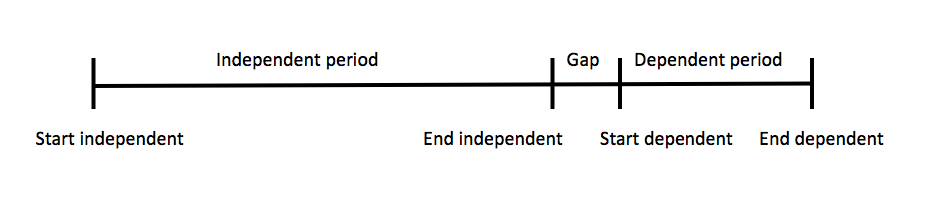

In [45]:
# define start independent period as the first available date
start_independent = first_date

# define end dependent period as the last available date
end_dependent = last_date

# set dependent period equal to 1 month
start_dependent = last_date -  timedelta(days=30)

# set gap of 1 day between end independent and start dependent
end_independent = start_dependent - timedelta(days=1)

In [47]:
# get an overview
print(f"start independent: {start_independent}\n"
      f"end independent: {end_independent}\n\n"
      f"start dependent: {start_dependent}\n"
      f"end dependent : {end_dependent}")


start independent: 2007-01-08 08:59:02
end independent: 2008-11-30 19:13:38

start dependent: 2008-12-01 19:13:38
end dependent : 2008-12-31 19:13:38


# 4. Data Preparation

## 4.1. Customer Selection

When computing the **dependent** and **independent variables** (features), we can only use data from the respective relevant time periods. 

In other words, the **predictive features** should be computed on data that was available in the **independent period**. The **dependent variable** (i.e., which product family will be bought next) has to be computed based on data from the **dependent period**. 

In [69]:
# separate independent from dependent visits
independent_visits = visits[visits["VisitDate"]<=end_independent]
dependent_visits = visits[(visits["VisitDate"]>=start_dependent) & (visits["VisitDate"]<= end_dependent)]


## 4.2. Features

### 4.2.1. RFM

The **RFM variables** represent the ``recency``, ``frequency`` and ``monetary values`` of actual purchases. Hence, we start by selecting the visits in the **independent period** that led to **a purchase** (i.e., ``Amount`` > 0).

In [70]:
# subset for visits that led to a purchase
visit_with_purchase = independent_visits[independent_visits["Amount"]>0]

The RFM variables should be **computed per customer**. Therefore, we need to **group** the visits **by** ``customerID``. 

In [71]:
# group data by customer
visit_group_by_customer = visit_with_purchase.groupby("CustomerID")

In [72]:
# show
visit_group_by_customer.head()

,VisitID,CustomerID,SalesRepresentativeID,VisitDate,Amount,PaymentTerm,Outcome
161485,54952660,1395284,20126680425436,2007-04-17 12:30:45,9.5,cash,SALES
161486,53735790,1249987,18934048107254,2007-03-08 18:54:58,16.9,cash,SALES
161487,53936653,1401189,20126680425436,2007-03-15 13:13:48,9.5,cash,SALES
161488,54235805,718421,23186288605042,2007-03-26 11:31:36,6.4,cash,SALES
161489,54985253,20421672162248,20126680425436,2007-04-18 09:22:03,8.5,cash,SALES
...,...,...,...,...,...,...,...
240089,66645424,21914764216840,19946584592834,2008-05-07 17:54:49,15.5,cash,SALES
240095,65566024,22725652312440,24034952445848,2008-04-01 17:12:58,8.0,cash,SALES
240199,71325178,71186161,24034952445848,2008-09-30 18:05:24,33.2,cash,SALES
240249,60547529,58281092,18934048107254,2007-10-04 15:47:25,7.3,cash,SALES


**Recency**

Calculate the **recency**, i.e. the number of days since the last purchase in the independent period.

In [73]:
# calculate recency
recency = pd.DataFrame(end_independent - visit_group_by_customer["VisitDate"].max()).reset_index()
recency.columns = ["CustomerID", "recency"]
recency["recency"] = recency["recency"].apply(lambda x: x.days)


In [74]:
# show
recency

,CustomerID,recency
0,687782,117
1,718230,41
2,718236,83
3,718247,97
4,718257,27
...,...,...
5152,25941076475846,16
5153,25943376453650,20
5154,25956568428048,41
5155,25983044516642,228


**Frequency**

Calculate the **frequency**, i.e. the number of purchases in the independent period.

In [78]:
# calculate frequency
frequency = pd.DataFrame(visit_group_by_customer["VisitID"].count()).reset_index()
frequency.columns = ["CustomerID", "frequency"]

In [79]:
# show
frequency

,CustomerID,frequency
0,687782,15
1,718230,20
2,718236,14
3,718247,7
4,718257,30
...,...,...
5152,25941076475846,2
5153,25943376453650,1
5154,25956568428048,2
5155,25983044516642,2


**Monetary value**

Calculate the **monetary value**, i.e. the total amount spent by a customer in the independent period.

In [81]:
# monetary value
monetary_value = pd.DataFrame(visit_group_by_customer["Amount"].sum()).reset_index()
monetary_value.columns = ["CustomerID", "monetary_value"]


In [82]:
# show
monetary_value


,CustomerID,monetary_value
0,687782,167.0
1,718230,204.9
2,718236,127.5
3,718247,42.6
4,718257,260.3
...,...,...
5152,25941076475846,14.3
5153,25943376453650,4.9
5154,25956568428048,21.3
5155,25983044516642,12.5


Finally, we need to **merge** the RFM variables into one dataframe

In [87]:
# merge into one dataframe
RFM_variables = pd.merge(pd.merge(recency, frequency, on="CustomerID"), monetary_value, on="CustomerID")

# check
RFM_variables

,CustomerID,recency,frequency,monetary_value
0,687782,117,15,167.0
1,718230,41,20,204.9
2,718236,83,14,127.5
3,718247,97,7,42.6
4,718257,27,30,260.3
...,...,...,...,...
5152,25941076475846,16,2,14.3
5153,25943376453650,20,1,4.9
5154,25956568428048,41,2,21.3
5155,25983044516642,228,2,12.5


### 4.2.2. Product History

In addition to the RFM variables, we would also like to use **the following variables as predictive features: 

1. The **number of products bought in each product family** during the independent period 
2. The **last product family bought** in the independent period 

The information we need to compute these variables can be found in the ``VisitDetails`` dataframe. In other words, we need to extract the information related to the **visits in the independent period** from the ``VisitDetails`` dataframe.

In [142]:
# get all the visits from independent period
visit_ids_indep = independent_visits["VisitID"]

# get the visitdetails for all the unique visits from independent period
visitdetails_indep = visitdetails[visitdetails["VisitID"].isin(visit_ids_indep)]

As we also need information from the ``Products`` dataframe (for example, the product family) and the ``Visits`` dataframe (for example, the customerID), we have to **merge** these three dataframes together. 

In [143]:
# merge the VisitDetails with Visits
visitdetails_indep = pd.merge(visitdetails_indep, visits, on="VisitID", how="left")

# merge the VisitDetails with Products
visitdetails_indep = pd.merge(visitdetails_indep, products, on="ProductID", how="left")

# check
visitdetails_indep.head(3)

,VisitDetailID,ProductID,Quantity,VisitID,CustomerID,SalesRepresentativeID,VisitDate,Amount,PaymentTerm,Outcome,Category,Family,Price
0,56012184,23686,1,56012182,719093,23186288605042,2007-05-22 12:10:02,13.2,cash,SALES,Product,Scoop Ice,3.7
1,56012248,290318682,1,56012247,878382,19946584592834,2007-05-22 12:07:00,4.1,cash,SALES,Product,Scoop Ice,4.1
2,56012265,23727,1,56012264,719150,23186288605042,2007-05-22 12:11:20,8.9,cash,SALES,Product,Cups,8.9


**Number of products bought in each product family**

Calculate the number of products bought in each product family per customer in the independent period.

In [144]:
# get number of each product family bought by customers
# get number of each product family bought by customers
family_counts_indep = visitdetails_indep.groupby(by=['CustomerID','Family'], as_index=False)[['Quantity']].sum()
family_counts_indep.head()


,CustomerID,Family,Quantity
0,687782,Assortments,3
1,687782,Coffee,1
2,687782,Garniture,1
3,687782,Hand Ice,7
4,687782,Scoop Ice,10


In [145]:
family_counts_indep = family_counts_indep.pivot_table(index="CustomerID", columns="Family", values="Quantity", fill_value=0)

**Last product family bought**

Extract the last product family bought for each customer in the independent period.

In [102]:
# get last product family bought
#sort by customer id and then the visitdates get sorted afterwards
last_product = visitdetails_indep.sort_values(['CustomerID', "VisitDate"])

#group by can you see as making a dataframe on the fly for each customer id, then the last one gets taken because we sorted by visitdate, then after tail we create a new dataframe on the fly with customerID and Family
last_product = last_product.groupby("CustomerID").tail(1)[["CustomerID", "Family"]]

last_product.columns = ["CustomerID", "last_family_indep"]

last_product["last_family_indep"] = last_product["last_family_indep"].fillna("UNKNOWN")

last_product.head(3)

,CustomerID,last_family_indep
108372,687782,Scoop Ice
110812,718230,Cups
104304,718236,Hand Ice


## 4.3. Dependent Variable

As we want to predict which product (or product family: see later) a customer is most likely to buy next, our **dependent variable** will be the **first product** (or product family) that a customer has bought **in the dependent period**. 

The information we need to **compute these variables** can be found in the ``VisitDetails`` dataframe.

In [103]:
# get all the visits from dependent period
visit_ids_dep = dependent_visits["VisitID"]

# get the visitdetails for all the unique visits from dependent period
visitdetails_dep = visitdetails[visitdetails["VisitID"].isin(visit_ids_dep)]

# merge the visitdetails with visits
visitdetails_dep = pd.merge(visitdetails_dep, visits, on="VisitID", how="left")

# check
visitdetails_dep.head()

,VisitDetailID,ProductID,Quantity,VisitID,CustomerID,SalesRepresentativeID,VisitDate,Amount,PaymentTerm,Outcome
0,73488071,23783,1,73488066,876766,19946584592834,2008-12-16 18:09:05,39.7,cash,SALES
1,73488410,21985480107044,1,73488409,71528183,18934048107254,2008-12-16 18:13:31,18.6,cash,SALES
2,73488411,46331520,1,73488409,71528183,18934048107254,2008-12-16 18:13:31,18.6,cash,SALES
3,73488412,60444646,1,73488409,71528183,18934048107254,2008-12-16 18:13:31,18.6,cash,SALES
4,73488416,290318678,1,73488415,1245602,18934048107254,2008-12-16 18:13:45,4.1,cash,SALES


**4.3.1 First product bought in dependent period**

Compute the first product bought in the dependent period. 

In [104]:
# sort dependent data by customer and date
visitdetails_dep_sorted = visitdetails_dep.sort_values(["CustomerID", "VisitDate"])

# get first product bought
first_product_dep = visitdetails_dep_sorted.groupby("CustomerID").head(1)[["CustomerID", "ProductID"]]

# show
first_product_dep.head()

,CustomerID,ProductID
1841,687782,23684
3492,718230,23782
1944,718257,19051680407644
7484,718263,23678
1945,718268,23678


**4.3.2 First product family bought in dependent period**

Compute the first product family bought in the dependent period.

In [105]:
# get family of first product bought
first_product_family_dep = pd.merge(first_product_dep, products[["ProductID", "Family"]], on="ProductID", how="left")

# set column names
first_product_family_dep.columns = ["CustomerID", "first_product_dep", "first_family_dep"]

# fill NA
first_product_family_dep["first_family_dep"] = first_product_family_dep["first_family_dep"].fillna("UNKNOWN")

# check
first_product_family_dep.head()

,CustomerID,first_product_dep,first_family_dep
0,687782,23684,Scoop Ice
1,718230,23782,Ice Cakes
2,718257,19051680407644,Ice Cakes
3,718263,23678,Scoop Ice
4,718268,23678,Scoop Ice


**Visually inspect** the distribution of first bought products (``ProductID``) in the dependent period. 

So the ``x-axis`` should contain the different products, whereas the ``y-axis`` will represent the number of times a product was bought as first product in the **dependent period**. 

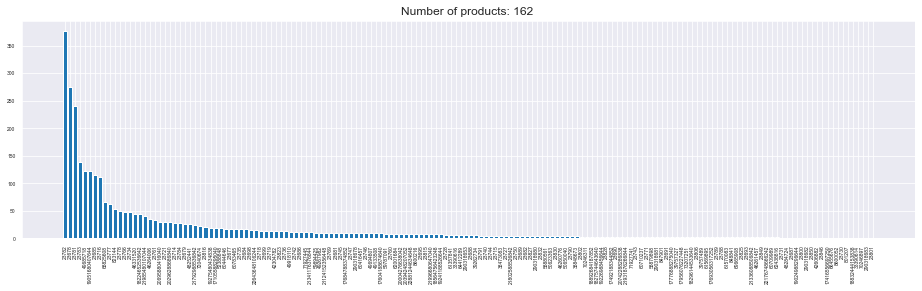

In [136]:
# get counts per product
product_counts = first_product_family_dep["first_product_dep"].value_counts()

# get products
names = product_counts.index

# plot
plt.figure(figsize=(16, 4))
plt.title("Number of products: %s "  %len(product_counts))
plt.bar(range(len(product_counts)), product_counts)
plt.xticks(range(len(product_counts)), names, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=5)
plt.show()

As you can see, most of the products are **only bought a couple of times**. This will decrease the **performance** of the model a lot since the model will only see some products as dependent only a couple of times. We are going to **reduce this number** by **thresholding** the amount of products in dependent period and **replacing products below this threshold by their respective product family**.

In a nutshell: 

1. If a product appears **at least 50 times** as first product bought in the dependent period -> The dependent variable equals the ``ProductID``.
2. If a product appears **less than 50 times** as first product bought in the dependent period -> The dependent variable should equal the product ``Family``. 

**4.3.3 Final dependent variable**

Let's compute the new dependent variable.

In [131]:

product_counts_2 = product_counts.reset_index()
product_counts_2.columns = ["first_product_dep", "quantity"]
product_counts_2

,first_product_dep,quantity
0,23782,376
1,23678,274
2,23781,240
3,23783,139
4,49685718,123
...,...,...
157,18832444153838,1
158,33390614,1
159,70246897,1
160,290318683,1


In [132]:
# compute new dependent variable
new_merge = pd.merge(first_product_family_dep, product_counts_2, on="first_product_dep", how="left")
new_merge

,CustomerID,first_product_dep,first_family_dep,quantity
0,687782,23684,Scoop Ice,16
1,718230,23782,Ice Cakes,376
2,718257,19051680407644,Ice Cakes,122
3,718263,23678,Scoop Ice,274
4,718268,23678,Scoop Ice,274
...,...,...,...,...
3057,25891544357838,23761,Individual Dessert,33
3058,25918793316554,68825608,Individual Dessert,66
3059,25941076475846,23783,Ice Cakes,139
3060,25978489378346,19051680407644,Ice Cakes,122


In [135]:
first_product_family_dep["dependent_variable"] = np.where(new_merge["quantity"]>50, new_merge["first_product_dep"], new_merge["first_family_dep"])

Let's check if our problem is resolved: **plot** the number of first bought products per product. 

In [139]:
# plot
product_thresh_counts = first_product_family_dep["dependent_variable"].value_counts()

# get families
names = product_thresh_counts.index

# show
product_thresh_counts


23782                 376
23678                 274
Hand Ice              255
23781                 240
Ice Cakes             237
Individual Dessert    225
Scoop Ice             210
Meals                 159
23783                 139
Coffee                129
49685718              123
19051680407644        122
23685                 115
23716                 111
Cups                   93
68825608               66
23777                  63
823144                 53
Assortments            35
BIG                    19
Garniture              17
POS inside              1
Name: dependent_variable, dtype: int64

In [140]:
first_product_family_dep = first_product_family_dep[first_product_family_dep["dependent_variable"] != "POS inside"]

For our **basetable**, we will only need the ``CustomerID`` to merge with our independent features) and the ``dependent variable``.

In [146]:
# only keep CustomerID and thresholded products
dependent = first_product_family_dep[["CustomerID", "dependent_variable"]]

# show
dependent.head()

,CustomerID,dependent_variable
0,687782,Scoop Ice
1,718230,23782
2,718257,19051680407644
3,718263,23678
4,718268,23678


# 5.  Basetable

To create the **final basetable**, we still need to complete the following steps: 

1. **Merge** the necessary datasets. 
2. **Split** the data into training, validation and test set (60-20-20).
3. **Seperate** the sets into the features on the one hand, and the dependent variable on the other hand.
4. **Standardize** the numeric features. 
5. Create **dummy variables** for categorical features such as ``last_family_indep``.
6. Encode the **categorical** dependent variable (first_product_dep_thresh) into numbers.

## 5.1. Merge datasets

In [147]:
# merge datasets
basetable = pd.merge(RFM_variables, last_product, on="CustomerID", how="inner")
basetable = pd.merge(basetable, family_counts_indep, on="CustomerID", how="inner")
basetable = pd.merge(basetable, dependent, on="CustomerID", how="inner")

# check
basetable.head()

,CustomerID,recency,frequency,monetary_value,last_family_indep,Assortments,BIG,Coffee,Cups,Garniture,Hand Ice,Ice Cakes,Individual Dessert,Meals,POS inside,Scoop Ice,dependent_variable
0,687782,117,15,167.0,Scoop Ice,3,0,1,0,1,7,0,0,0,0,10,Scoop Ice
1,718230,41,20,204.9,Cups,0,0,2,9,0,7,2,8,1,0,1,23782
2,718257,27,30,260.3,Hand Ice,1,0,0,1,0,29,0,1,0,0,0,19051680407644
3,718263,13,27,340.7,Hand Ice,1,0,0,0,0,20,0,0,0,0,19,23678
4,718268,13,22,205.1,Hand Ice,0,0,0,0,0,20,0,1,0,0,1,23678


## 5.2. Train - Validation -Test split

In [148]:
# split data into training, validation and test set (60-20-20)
train, val_test = train_test_split(basetable, test_size=0.40, random_state=21)
val, test = train_test_split(val_test, test_size=0.50, random_state=57)

## 5.3. Separate the dependent variable and the features (optional)

In [149]:
# get features and labels
train_X = train.iloc[:, 1:-1]
train_y = train.iloc[:, -1]

val_X = val.iloc[:, 1:-1]
val_y = val.iloc[:, -1]

test_X = test.iloc[:, 1:-1]
test_y = test.iloc[:, -1]

## 5.4. Standardization

In [150]:
# standardize the numeric features 

# define the numeric features
numeric_features = ["recency", "frequency", "monetary_value"]

# import min max scaler
from sklearn.preprocessing import MinMaxScaler

# initialize the scaler
scaler = MinMaxScaler()

# fit scaler on all the numeric variables
scaler.fit(train_X[numeric_features])

# scale features
train_X[numeric_features] = scaler.transform(train_X[numeric_features])
val_X[numeric_features] = scaler.transform(val_X[numeric_features])
test_X[numeric_features] = scaler.transform(test_X[numeric_features])


## 5.5. Dummy variables

In [151]:
# create dummy variables for categorical features
train_X = pd.get_dummies(train_X)
val_X = pd.get_dummies(val_X)
val_X = val_X.reindex(columns = train_X.columns, fill_value=0)
test_X = pd.get_dummies(test_X)
test_X = test_X.reindex(columns = train_X.columns, fill_value=0)

## 5.6. Encode dependent variable

In [152]:
# encode the categorical dependent variable into numbers
lab_encoder = LabelEncoder()

# fit the label encoder on the training data
lab_encoder.fit(train_y.astype(str))

# apply the fitted label encoder in order to transform the categorical dependent variable into numbers
train_y = lab_encoder.transform(train_y.astype(str))
val_y = lab_encoder.transform(val_y.astype(str))
test_y = lab_encoder.transform(test_y.astype(str))


# 6. Modeling

In previous cases, our **dependent variable** was a **binary** variable. For example, in the case of churn, we modelled whether someone was likely to churn (1) or not (0). To do so, we used a **logistic regression**. 

In a **cross-sell** case, the **goal** is to predict which product the customer is most likely to buy next. Hence, there are more than two possible discrete outcomes, i.e. the dependent variable consists of more than two categories. This is called a **multiclass classification** problem. 

To solve this, we will use **2 different algorithms** (``multinomial logistic regression`` and ``k-nearest neighbours``) and compare these to the **baseline** (i.e., random) **model**. 

## 6.1. Multinomial Logistic Regression

A **multinomial logistic regression** generalizes logistic regression to multiclass problems (i.e., the dependent variable consists of K instead of 2 categories). 

Regression models are based on equations (you do not have to know the mathematics behind these equations!)

For a **logistic regression**, we have 1 equation that models the likelihood of something happening (1) relative to not (0). 

For a **multinomial logistic regression**, we have **K-1 equations**. Each equation models the likelihood of a certain scenario happening relative to a baseline. 

**An example** will make this clearer: Suppose we want to predict if someone's favourite colour is ``red``, ``green`` or ``blue``. As we have **three categories**, the multinomial logistic regression will consist of 2 equations. Suppose **blue is our baseline**, then we will have the following equations: 

        (1) Equation 1: Likelihood that someone's favourite colour will be red relative to blue.
        (2) Equation 2: Likelihood that someone's favourite colour will be green relative to blue. 

Finally, the outcome of a multinomial logistic regression consists of the **likelihoods of the different possible outcomes**. The outcome with the highest likelihood, will be the predicted outcome.

Create a **predictive model** using a multinomial logistic regression (set the number of iterations ``max_iter`` equal to 1000):

In [ ]:
# define multinomial logistic regression model


# fit model on training set


# make predictions on validation set


Calculate the **accuracy** of the model 

In [ ]:
# get accuracy


# check


Create a **barplot** of the **predicted outcomes**. 

Thus the ``x-axis`` should contain the products and the ``y-axis`` should represent the number of times a product has been predicted as the outcome. 

In [ ]:
# get predicted labels and counts




Similarly, create a **barplot** of the **true outcomes**. 

In [ ]:
# get true labels and counts




## 6.2. KNN

**K-Nearest Neighbours** (KNN) is an algorithm that can be used for classification as well as regression problems. 

KNN is based on the idea that similar things are **close to each other**. In other words, observations with the same outcome will be close to each other in terms of distance. 

**Remember**: observations can be represented by vectors in space. Hence, the distance between two observations can be calculated as the **distance** between the two vectors representing them.

The **KNN algorithm** goes as follows. For each new observation: 

1. Compute the **distance** between the new observation and all observations in the training set.
2. Take the K closest training observations, i.e. those with the smallest distance to the new observation. These are the **K-nearest neighbours**. 
3. Take the **label** (i.e., dependent variable or true outcome) of those training observations. 
4. The **predicted outcome** for the new observation is the **mode** (=the one that occurs the most) of the K true outcomes.

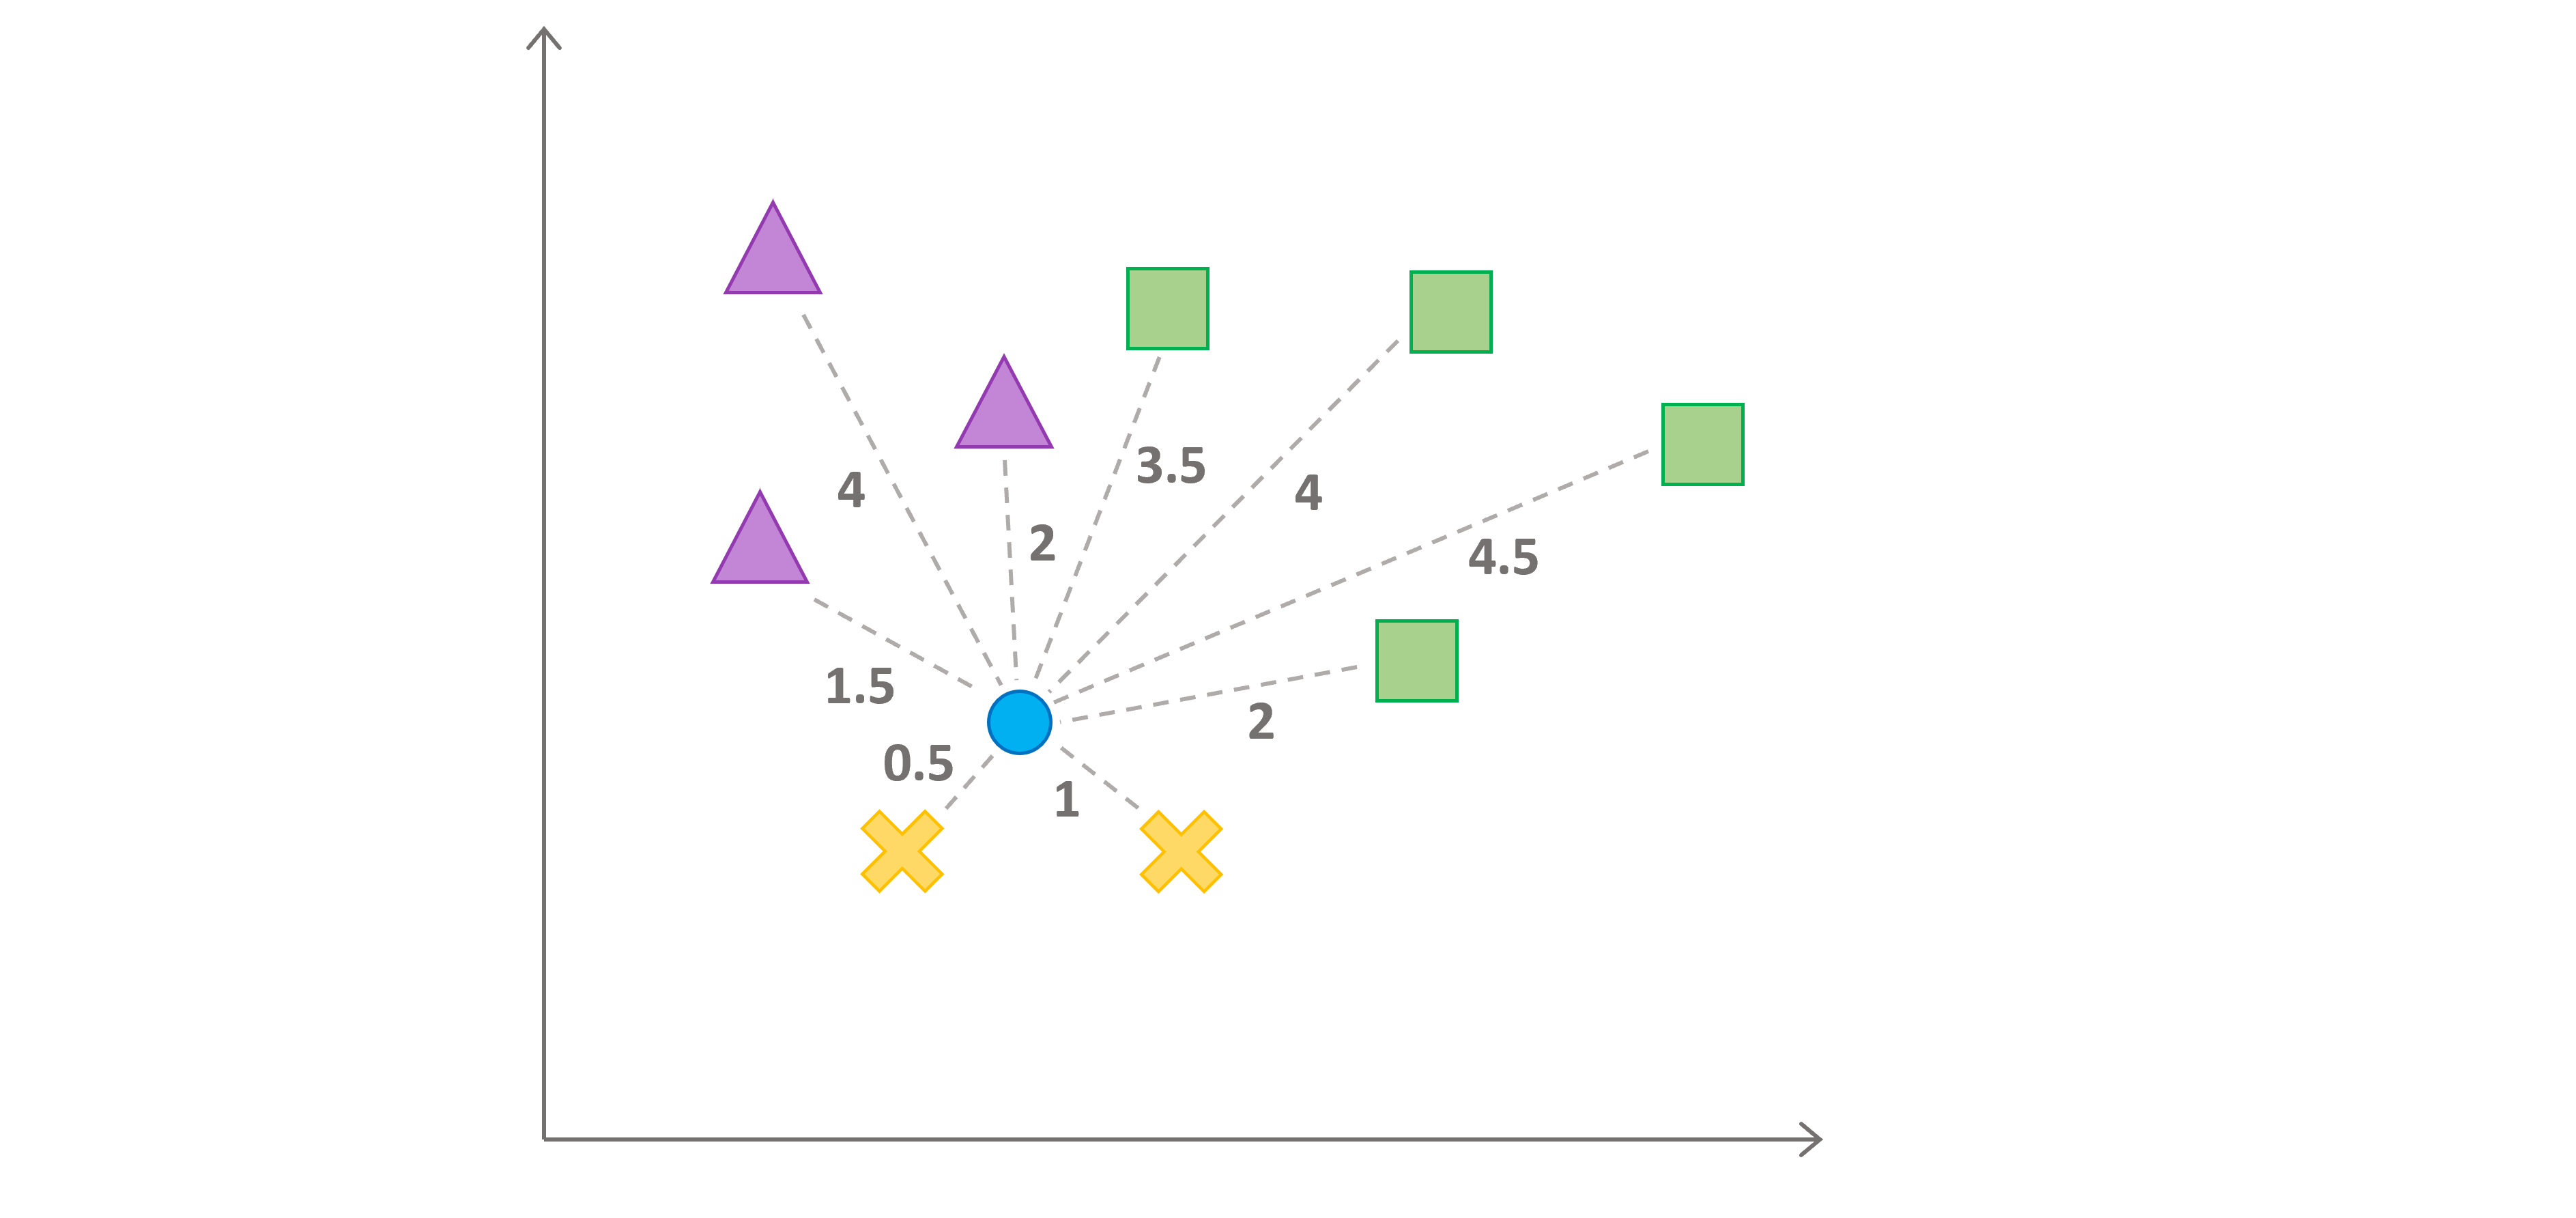

Create a **predictive model** using the KNN algorithm with ``K``=20.

In [ ]:
# initialize the KNN classifier with K = 20
knn = KNeighborsClassifier(n_neighbors=20)

# fit the classifier on the training set with only RFM variables (distance between productFamilies not possible)
knn.fit(train_X.iloc[:, :3], train_y)

# get predictions
knn_val_preds = knn.predict(val_X.iloc[:, :3])

Compute the **accuracy** of the predictive model.

In [ ]:
# get accuracy
knn_val_acc = accuracy_score(val_y, knn_val_preds)

# check
print("KNN val accuracy: %s %%" %(knn_val_acc * 100))

## 6.3. Random Model

Compute the predictions of a **random model**. This is our **baseline model** against which we can compare the other models. 

In [ ]:
# get most bought product 


# make val predictions


In [ ]:
# get accuracy


# check


## 7. Model Evaluation

Based on the accuracy, we may **assume** that the multinomial model is the **best model**. 

As a final step, create the **final model** and **calculate its accuracy**. 

In [ ]:
# join training and validation set (to create one big training set)



In [ ]:
# define multinomial logistic regression model


# fit model on big training set
mlr_model.fit(train_big_X, train_big_y)

# make predictions on test set


In [ ]:
# get accuracy


# check


Create a **barplot** of the **predicted outcomes**.

In [ ]:
# get predicted labels and counts




Create a **barplot** of the **actual outcomes**.

In [ ]:
# get true labels and counts




In [ ]:
# multiclass confusion matrix
multilabel_confusion_matrix(test_y, mlr_test_preds)